In [360]:
import os
import cv2 as cv
import numpy as np


In [361]:
# Load raw cell images
raw_cells_dir = "../../data/digits/raw_cells"
raw_cell_images = []

for session in os.listdir(raw_cells_dir):
    session_path = os.path.join(raw_cells_dir, session)
    if not os.path.isdir(session_path):
        continue
    for fname in os.listdir(session_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(session_path, fname)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if img is not None:
                raw_cell_images.append(img)

print(f"Loaded {len(raw_cell_images)} raw cell images")


Loaded 81 raw cell images


In [362]:
def remove_grid_borders(cell_image, debug=False):
    """
    Remove grid borders from a cell image by iteratively clearing black pixels from the edges,
    and return the cleaned image (digit only, background white).
    Steps:
    1. Darken the image by 30%.
    2. Blur the image.
    3. Binarize the image (background white, digit black) using Otsu's thresholding.
    4. For each edge, clear strips as long as the black percent is above threshold.
    5. Set those strips to white in the original image.
    6. Binarize the final cleaned image and return it (digit black, background white).
    """

    blur_ksize = 3
    max_val = 255
    black_percent_threshold = 0.35
    edge_strip_width = 3
    max_strips = 35

    img = cell_image.copy()
    # img = (img.astype(np.float32) * 0.7).clip(0, 255).astype(np.uint8)
    img_blur = cv.GaussianBlur(img, (17, 17), 0)
    _, img_bin = cv.threshold(img_blur, 0, max_val, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    img_bin = cv.bitwise_not(img_bin)

    h, w = img_bin.shape
    cleaned = cell_image.copy()

    for side in ['top', 'bottom', 'left', 'right']:
        for i in range(max_strips):
            if side == 'top':
                y1, y2 = i * edge_strip_width, min((i + 1) * edge_strip_width, h)
                x1, x2 = 0, w
            elif side == 'bottom':
                y1, y2 = h - (i + 1) * edge_strip_width, h - i * edge_strip_width
                y1 = max(y1, 0)
                x1, x2 = 0, w
            elif side == 'left':
                x1, x2 = i * edge_strip_width, min((i + 1) * edge_strip_width, w)
                y1, y2 = 0, h
            elif side == 'right':
                x1, x2 = w - (i + 1) * edge_strip_width, w - i * edge_strip_width
                x1 = max(x1, 0)
                y1, y2 = 0, h

            roi = img_bin[y1:y2, x1:x2]
            total = roi.size
            black = np.count_nonzero(roi == 0)
            black_percent = black / total if total > 0 else 0

            if black_percent > black_percent_threshold:
                cleaned[y1:y2, x1:x2] = 255
            else:
                break



    if debug:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(cell_image, cmap='gray')
        axs[0].set_title('Original')
        axs[1].imshow(img_blur, cmap='gray')
        axs[1].set_title('Blurred')
        axs[2].imshow(img_bin, cmap='gray')
        axs[2].set_title('Binarized')
        axs[3].imshow(cleaned, cmap='gray')
        axs[3].set_title('Cleaned (White Strips)')
        for ax in axs:
            ax.axis('off')
        plt.show()

    return cleaned





In [363]:
def process_cell(cell_image, debug=False):
    """
    Process cell image to remove grid borders, clean up the image, and sharpen the digit
    """
    cleaned = remove_grid_borders(cell_image, debug=debug)


    if len(cleaned.shape) == 3:
        gray = cv.cvtColor(cleaned, cv.COLOR_BGR2GRAY)
    else:
        gray = cleaned.copy()
    
    # Light denoising
    cleaned = cv.medianBlur(gray, 3)
    
    # Enhance contrast
    cleaned = cv.convertScaleAbs(cleaned, alpha=1.3, beta=0)
    
    # Binary threshold (solid digit)
    _, binary = cv.threshold(cleaned, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    return binary



In [364]:
import matplotlib.pyplot as plt


In [365]:
# Simple function to test process_cell on a specific image
def test_process_cell(idx, debug=True):
    """Test process_cell function on a specific image"""
    if idx < len(raw_cell_images):
        raw_img = raw_cell_images[idx]
        print(f"Testing image {idx}")
        print(f"Raw image shape: {raw_img.shape}")
        print(f"Raw image range: {raw_img.min()} to {raw_img.max()}")
        
        # Process the image
        processed_img = process_cell(raw_img, debug=debug)
        
        # Display side-by-side comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Raw image
        ax1.imshow(raw_img, cmap='gray')
        ax1.set_title(f'Raw Image {idx}\nSize: {raw_img.shape}')
        ax1.axis('off')
        
        # Processed image
        ax2.imshow(processed_img, cmap='gray')
        ax2.set_title(f'Processed Image {idx}\nSize: {processed_img.shape}')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Processed image range: {processed_img.min()} to {processed_img.max()}")
        
        return processed_img
    else:
        print(f"Index {idx} out of range. Available images: 0-{len(raw_cell_images)-1}")
        return None


In [366]:
# Test the process_cell function
print(f"Loaded {len(raw_cell_images)} raw cell images")
print("Use test_process_cell(idx) to test on a specific image")
print("Example: test_process_cell(0, debug=True)")


Loaded 81 raw cell images
Use test_process_cell(idx) to test on a specific image
Example: test_process_cell(0, debug=True)


Testing image 34
Raw image shape: (400, 400)
Raw image range: 114 to 215


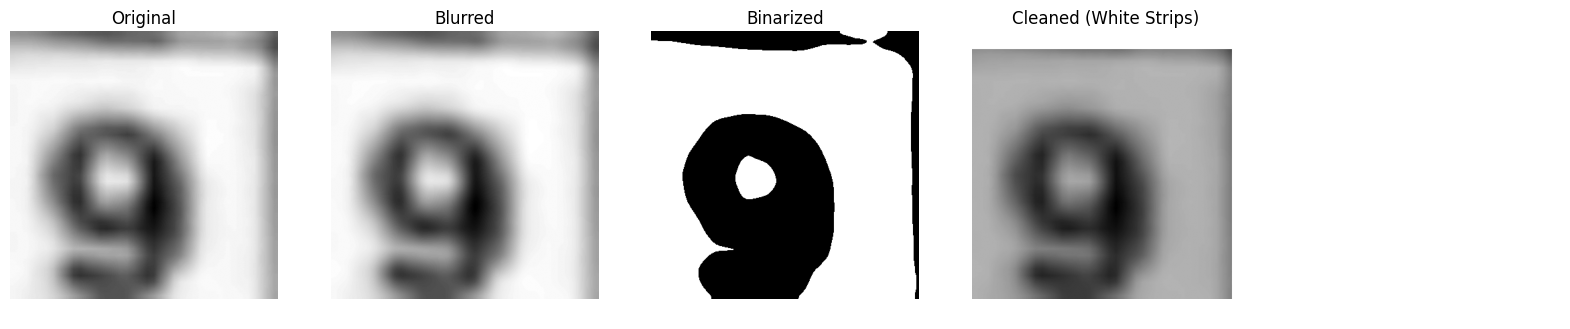

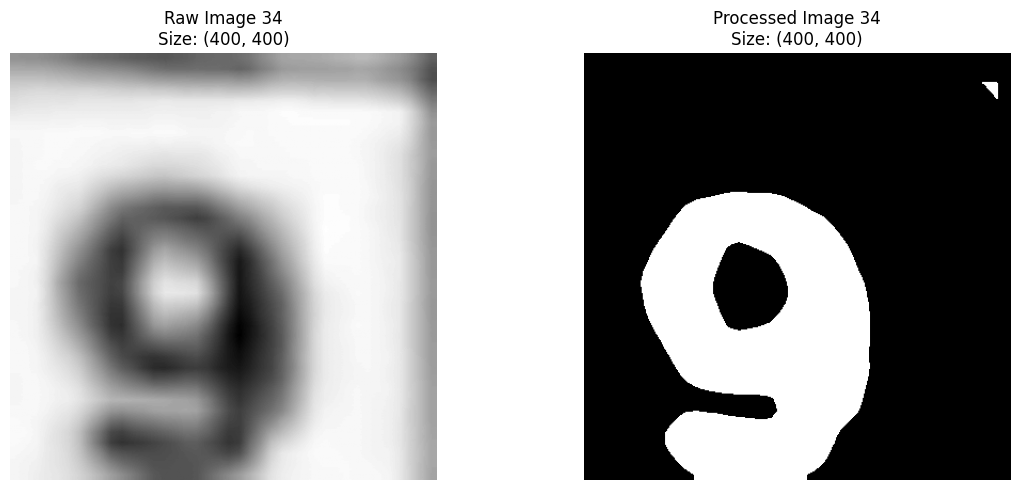

Processed image range: 0 to 255


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(400, 400), dtype=uint8)

In [367]:
test_process_cell(34, debug=True)


Testing image 55
Raw image shape: (400, 400)
Raw image range: 121 to 216


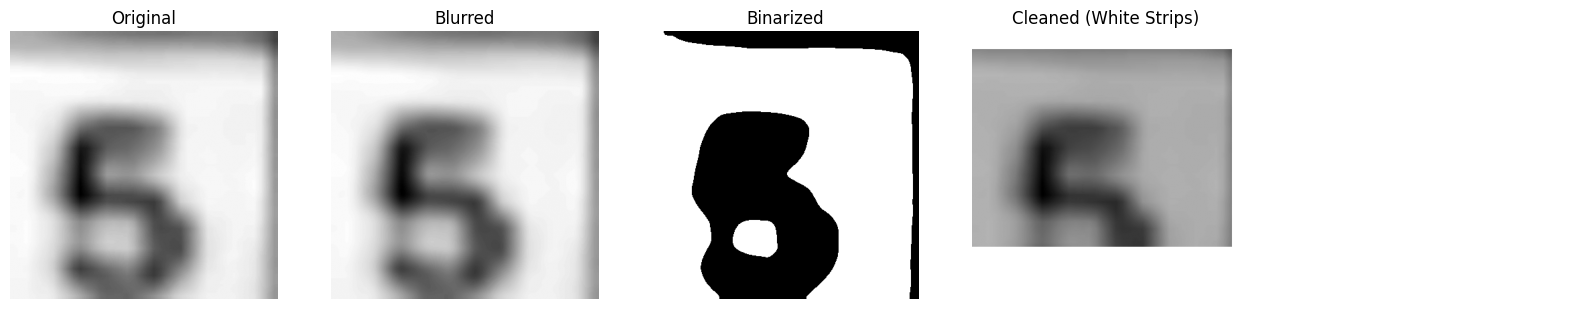

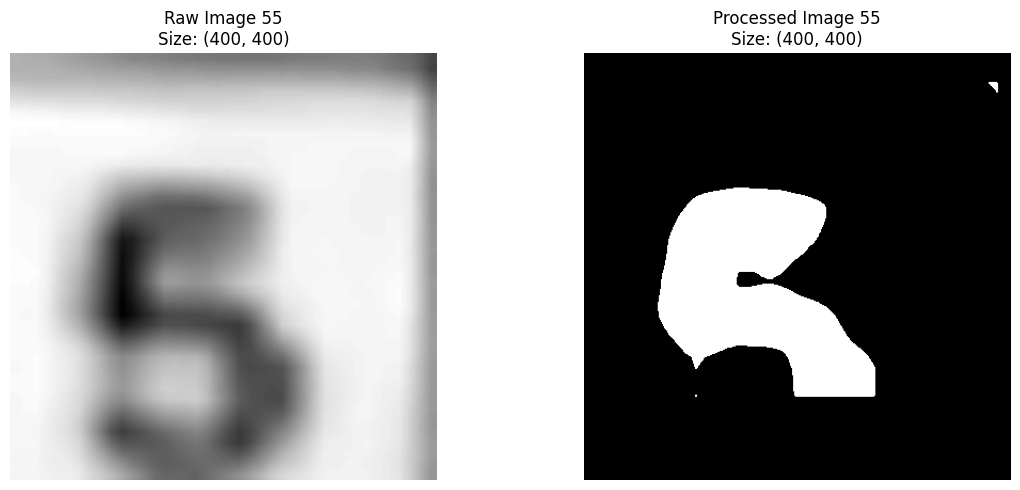

Processed image range: 0 to 255


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(400, 400), dtype=uint8)

In [368]:
# Test the improved grid removal function
test_process_cell(55, debug=True)


Testing image 1
Raw image shape: (400, 400)
Raw image range: 92 to 215


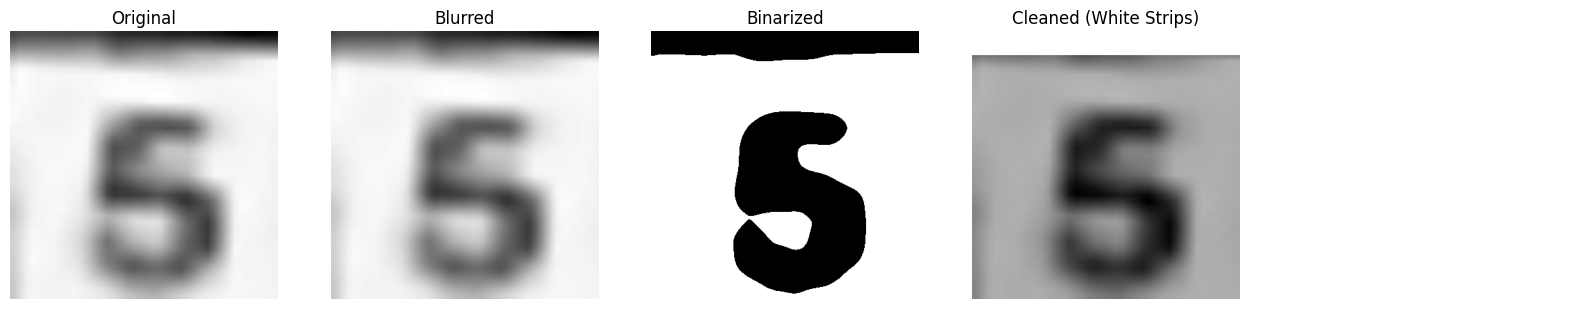

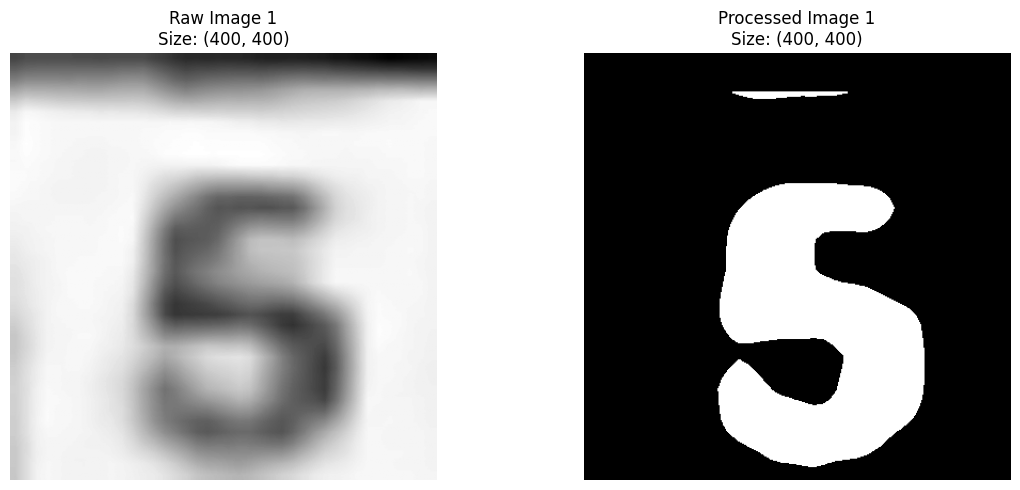

Processed image range: 0 to 255


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(400, 400), dtype=uint8)

In [371]:
test_process_cell(1, debug=True)